# Plotting Distane from Present-Day Grounding Line

# 1. Load Dataset

In [1]:
import xarray as xr
import gcsfs
gcs = gcsfs.GCSFileSystem(token=None, access='read_only')

In [2]:
snapshots1ka = xr.open_zarr(gcs.get_mapper('gs://ldeo-glaciology/paleo_ensemble/snapshots1ka.zarr'))
snapshots1ka = snapshots1ka.chunk(chunks={'time':1})

In [3]:
# Add these codes to decrease CPU and memory use, which avoids the workers from being killed.
from dask.distributed import Client
import dask_gateway

gateway = dask_gateway.Gateway()

# Close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
         cluster = gateway.connect(c.name)
         cluster.shutdown()  

# Increase worker memory
options = gateway.cluster_options()
options.worker_memory = 16

cluster = gateway.new_cluster(cluster_options=options)

[]


In [4]:
# Start up cloud cluster with 20 workers
cluster.scale(20)
client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.69c4581f18b74d0ca1375825d85141e3/status,


# 2. Ice Type Plot

To begin with, I determined two points to define a section in the Weddell Sea sector. The selected two points were (-1.1e6, 1.1e6) and (-0.7e6, 0). The analysis was performed on the present condition with all the ensemble parameters averaged. The defined section is indicated on the ice-type plot below.

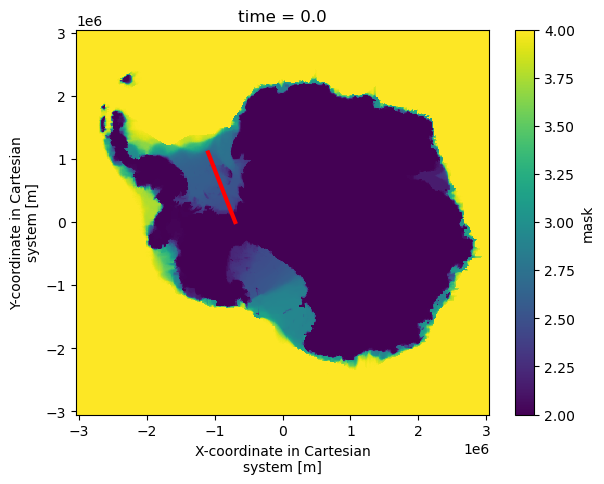

In [6]:
import matplotlib.pyplot as plt
snapshots1ka.mask.isel(time=124).mean({"par_esia","par_ppq","par_prec","par_visc"}).plot(x='x',y='y',size = 5)
x = [-1.1e6, -0.7e6]
y = [1.1e6, 0]
plt.plot(x,y,color="red", lw=3)

# 3. Ice Type Interpolation

Next, I used advanced interpolation to determine the position of the present-day grounding line on the defined section. I defined the point with mask = 2.5 to be the present-day grounding line because it is the transition point between grounded ice (mask = 2.0) and floating ice (mask = 3.0). For advanced interpolation, I created new xarray objects that correspond to the x- and y- coordinates.

In [8]:
import numpy as np
# the x coordinates for the 1000 points between points (-1.1e6,1.1e6) and (-0.7e6,0) are defined
x = np.linspace(-1.1e6, -0.7e6, 1000)
# the y coordinates for the 1000 points between points (-1.1e6,1.1e6) and (-0.7e6,0) are defined
y = np.linspace(1.1e6, 0, 1000)

# create xarray datasets
x = xr.DataArray(x, dims="z")
y = xr.DataArray(y , dims="z")

In [9]:
# Advanced interpolation
ice = snapshots1ka.mask.isel(time=124).mean({"par_esia","par_ppq","par_prec","par_visc"}).interp(x=x, y=y).values
ice

array([2.65576172, 2.65495648, 2.65417816, 2.65342674, 2.65270223,
       2.65200464, 2.65133395, 2.65069017, 2.6500733 , 2.64948334,
       2.64892028, 2.64834239, 2.64741572, 2.6465025 , 2.64560273,
       2.64471642, 2.64384356, 2.64298416, 2.64213821, 2.64130572,
       2.64048668, 2.6396811 , 2.63888897, 2.63811029, 2.63734507,
       2.63659331, 2.63563954, 2.63447387, 2.63324093, 2.63194072,
       2.63057382, 2.62920731, 2.62786771, 2.62655501, 2.62526923,
       2.62401035, 2.62277838, 2.62157332, 2.62039518, 2.61924394,
       2.61814377, 2.6176294 , 2.61710158, 2.61656031, 2.61600558,
       2.6154374 , 2.61485576, 2.61426067, 2.61365212, 2.61303012,
       2.61239467, 2.61174575, 2.61108339, 2.61040757, 2.60971829,
       2.609375  , 2.609375  , 2.609375  , 2.609375  , 2.609375  ,
       2.609375  , 2.609375  , 2.609375  , 2.609375  , 2.609375  ,
       2.609375  , 2.609375  , 2.609375  , 2.609375  , 2.609375  ,
       2.60884908, 2.60831144, 2.60777379, 2.60723614, 2.60669

In [11]:
# the position of the grounding line
np.min(np.where(ice < 2.5))

546

The position of the grounding line was computed to be the 546th point on the section.

In [14]:
# compute the x- and y- coordinates for the grounding line position
print("x coordinate:", x[546])
print("y coordinate:", y[546])

x coordinate: <xarray.DataArray ()>
array(-881381.38138138)
y coordinate: <xarray.DataArray ()>
array(498798.7987988)


The plot below shows the position of the grounding line on the defined section.

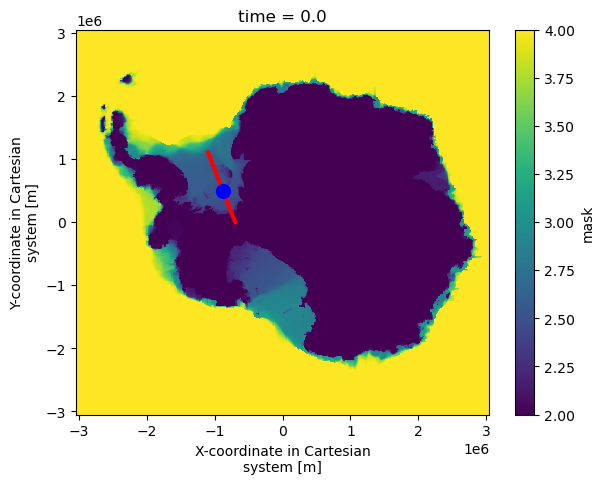

In [13]:
snapshots1ka.mask.isel(time=124).mean({"par_esia","par_ppq","par_prec","par_visc"}).plot(x='x',y='y',size = 5)
x1 = [-1.1e6, -0.7e6]
y1 = [1.1e6, 0]
plt.plot(x1,y1,color="red", lw=3)
plt.plot(x[546], y[546], color="blue", markersize=10,marker="o")

In [15]:
cluster.shutdown()